# Carve up 2+1D Spatiotemporal Space with Oriented Gabors

Now, define filters with a 3rd dimension!

In [1]:
#%matplotlib ipympl
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
pi = np.pi

def gauss_filter_3d(x, y, z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, norm=False):
    response = np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + 
                        (y - mu_y)**2 / (2 * sigma_y**2) + 
                        (z - mu_z)**2 / (2 * sigma_z**2)))
    if norm:
        response = response / ((sigma_x * sigma_y * sigma_z) * (2 * np.pi)**1.5)
    return response

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def calculate_sigma_scale(scale, reference_scale):
    xyscale = 0.4
    tscale=0.4
    #xyscale = (reference_scale / scale) ** (0.4)
    #tscale = (reference_scale / scale) ** (0.4)
    return (xyscale,tscale)

def radial_gaussian_3d(xs, ys, zs, scale, orientation, height, phase_offset=0, norm=False, reference_scale=1):
    mu_x, mu_y = pol2cart(scale, orientation)
    mu_z = height
    sigma_scale_space, sigma_scale_time = calculate_sigma_scale(scale, reference_scale)
    #print(sigma_scale_space)
    filt_sigma_xy = scale * sigma_scale_space
    filt_sigma_z = 1 * sigma_scale_time #scale * height * sigma_scale_time  # You might want to adjust this based on your specific requirement
    #print('center: ',mu_x,mu_y,mu_z)
    #print('sigma: ',filt_sigma_xy,filt_sigma_z)
    filt = gauss_filter_3d(xs, ys, zs, mu_x, mu_y, mu_z, filt_sigma_xy, filt_sigma_xy, filt_sigma_z, norm=norm)
    filt = filt * np.exp(1j * phase_offset)
    return filt


def quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, height, norm=False, separate_pairs=False):
    filter_real = radial_gaussian_3d(xs, ys, zs, scale, orientation, height, phase_offset=0, norm=norm)
    filter_imag = radial_gaussian_3d(xs, ys, zs, scale, orientation + np.pi, -1*height, phase_offset=pi, norm=norm)
    if(separate_pairs):
        filter = (filter_real, 1j*filter_imag)
    else:
        filter = filter_real + 1j*filter_imag
    return filter

## Plot a Demo

First a scatterplot

(-3.0, 3.0)

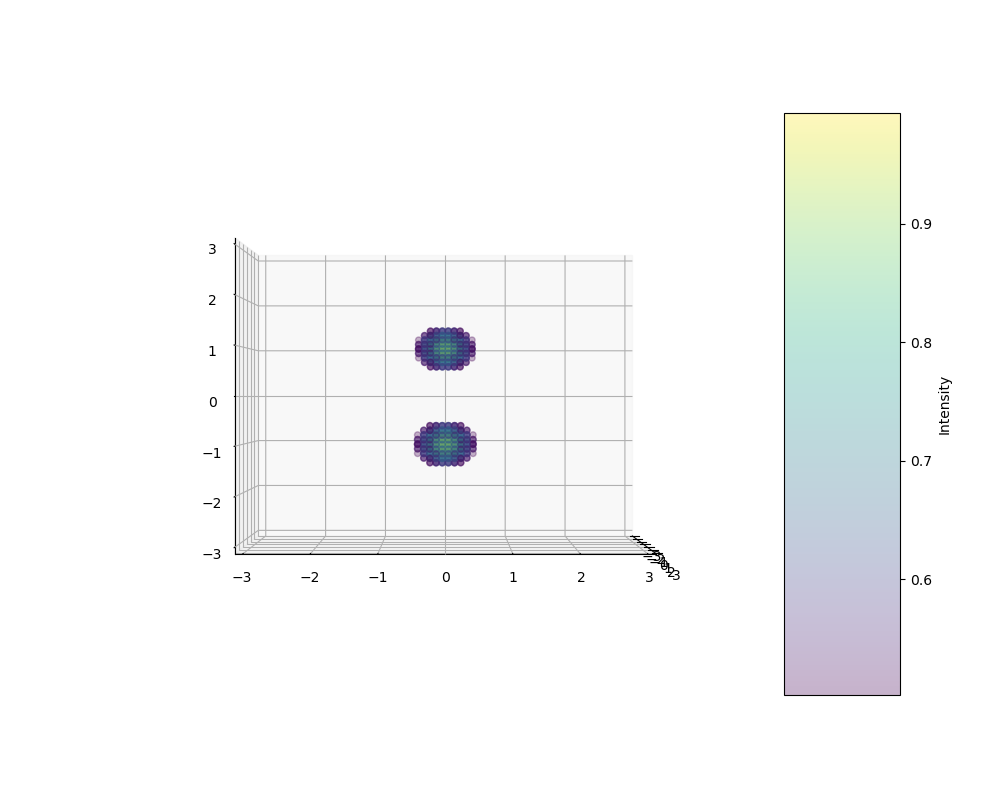

In [2]:
def plot_3d_quadrature_gaussian_filter(scale, orientation, height, xyspace=np.linspace(-6, 6, num=64), tspace=np.linspace(-6,6, num=64),ax=None):
    xs, ys, ts = np.meshgrid(xyspace, xyspace, tspace)
    
    filter = quadrature_gaussian_filter_3d(xs, ys, ts, scale, orientation, height, norm=False, separate_pairs=False)
    filter_amplitude = np.abs(filter)
    max_amplitude = np.max(filter_amplitude)

    fig= plt.figure(figsize=(10,8))
    if(ax==None):
        ax = fig.add_subplot(111, projection='3d')

    ax.view_init(0, 0, 0)

    #filter_amplitudes_normed = filter_amplitude / max_amplitude
    keep_mask = np.where(filter_amplitude > (max_amplitude/2))
    
    scatter = ax.scatter(xs[keep_mask], ys[keep_mask], ts[keep_mask], c=filter_amplitude[keep_mask], cmap='viridis', marker='o', alpha=0.3)
    
    cbar = fig.colorbar(scatter, ax=ax,aspect=5)
    cbar.set_label('Intensity')

    return(ax)

scale = 1
orientation = pi
height = 1

xyspace = np.linspace(-3,3, num=64)
tspace = np.linspace(-3,3, num=64)

ax = plot_3d_quadrature_gaussian_filter(scale, orientation, height, xyspace=xyspace, tspace=tspace)
ax.set_xlim(np.min(xyspace), np.max(xyspace))
ax.set_ylim(np.min(xyspace), np.max(xyspace))
ax.set_zlim(np.min(tspace), np.max(tspace))


In [3]:
def create_filter_mesh(scale,orientation,height,xyspace=np.linspace(-6,6,num=64),tspace=np.linspace(-6,6,num=64)):
    xs, ys, zs = np.meshgrid(xyspace, xyspace, tspace)
    filter = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, height, norm=False, separate_pairs=False)
    filter_amplitude = np.abs(filter)
    max_amplitude = np.max(filter_amplitude)
    keep_mask = np.where(filter_amplitude > (max_amplitude/2))    
    xs = xs[keep_mask]
    ys = ys[keep_mask]
    zs = zs[keep_mask]
    filter_amplitude = filter_amplitude[keep_mask]
    return(xs,ys,zs,filter_amplitude)

## Go through a range of scales and orientations and plot them all

In [4]:
# #pick our scales & centers
# scales = [1,2]
# orientations = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
# radii = [1,2,4]
# #setup space and time progression
# xyzpace = np.linspace(-10,10, num=64)
# tspace = np.linspace(-10,10,num=64)

# # Create the figure
# fig, axs = plt.subplots(len(orientations) * len(radii), len(scales), figsize=(15, 60), subplot_kw={'projection': '3d'})

# for j, height in enumerate(radii):
#     for i, orientation in enumerate(orientations):
#         for k, scale in enumerate(scales):
#             ax = axs[i * len(radii) + j, k]
#             xs,ys,zs,amps = create_filter_mesh(scale, orientation, height, xyspace,tspace)
#             ax.scatter(xs,ys,zs,c=amps,cmap='plasma',marker='.',alpha=0.3)

#             ax.set_xlim(np.min(xyspace), np.max(xyspace))
#             ax.set_ylim(np.min(xyspace), np.max(xyspace))
#             ax.set_zlim(np.min(tspace), np.max(tspace))
#             ax.set_xlabel('X')
#             ax.set_ylabel('Y')
#             ax.set_zlabel('Z')

#             #x, y, z = np.array([[-1*width,0,0],[0,-1*width,0],[0,0,0]])
#             #u, v, w = np.array([[2*width,0,0],[0,width,0],[0,0,5*width]])
#             #ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
#             #ax.set_axis_off()
        
# plt.tight_layout()
# plt.show()


## Plot them all on the same axis to see if this makes sense

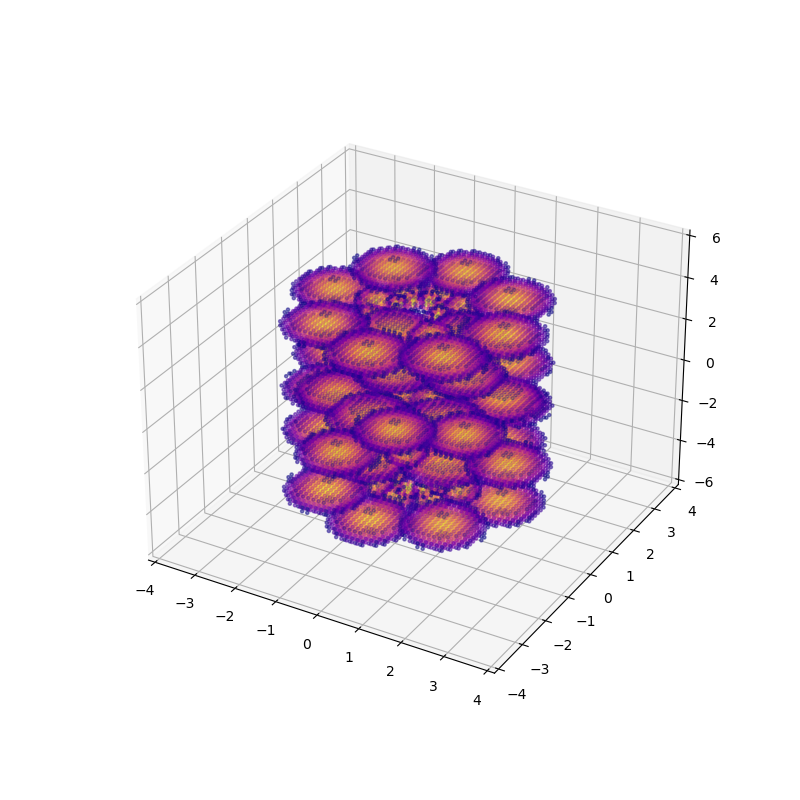

In [5]:
plt.clf()
#pick our scales & centers
scales = [0.5,1,2]
orientations = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
heights = [1,4]

xyspace = np.linspace(-4,4,num=64)
tspace = np.linspace(-6,6,num=64)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for j, height in enumerate(heights):
    for k, scale in enumerate(scales):
        for i, orientation in enumerate(orientations):
            # #0,0 special case
            # height=0
            # xs,ys,zs,amps = create_filter_mesh(scale,orientation,height)
            # ax.scatter(xs,ys,zs,c=amps,cmap='viridis',marker='.',alpha=0.3)
            
            for j, elevation in enumerate(scales):
                xs,ys,zs,amps = create_filter_mesh(scale,orientation,height,xyspace,tspace)
                ax.scatter(xs,ys,zs,c=amps,cmap='plasma',marker='.',alpha=0.2)
                
ax.set_xlim(np.min(xyspace), np.max(xyspace))
ax.set_ylim(np.min(xyspace), np.max(xyspace))
ax.set_zlim(np.min(tspace), np.max(tspace))
plt.show()


## How Does Power Fill up Space?

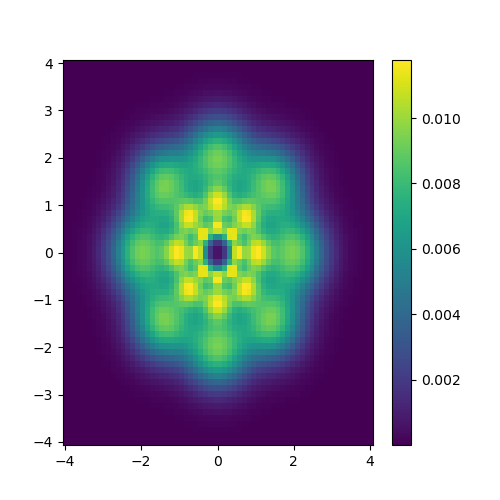

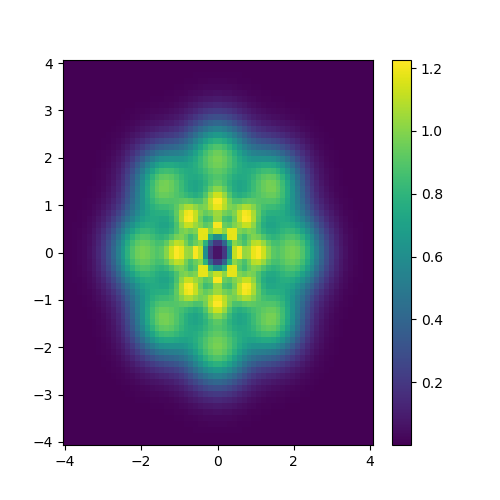

In [6]:
xyspace=np.linspace(-4,4,num=64)
tspace=np.linspace(-8,8,num=64)
xs, ys, zs = np.meshgrid(xyspace, xyspace, tspace)

filter_sum = np.zeros((len(xs),len(ys),len(zs)))
for height in [1]:
    for scale in [0.5,1,2]:
        for orientation in [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]:
            filter_sum += np.real(np.abs(quadrature_gaussian_filter_3d(xs, ys, zs, scale, 
                                                                       orientation, height, norm=False, separate_pairs=False)))**2
#full 3d plot
#plt.scatter(xs,ys,zs,c=filter_sum,cmap='plasma',marker='.',alpha=0.01)
#plt.show()

plt.clf()
plt.figure(figsize=(5, 5))
plt.pcolormesh(xyspace,xyspace,filter_sum[:,:,len(tspace)//2].squeeze())
plt.colorbar()
plt.show()
plt.figure(figsize=(5, 5))
plt.pcolormesh(xyspace,xyspace,filter_sum[:,:,len(tspace)//2+3].squeeze())
plt.colorbar()
plt.show()
# plt.figure(figsize=(5, 5))
# plt.pcolormesh(xyspace,xyspace,filter_sum[:,:,10].squeeze())
# plt.colorbar()
# plt.show()

## How do these look in space/time filter domain?
These filters were created in the fourier domain, what do they look lik in the spatial domain?

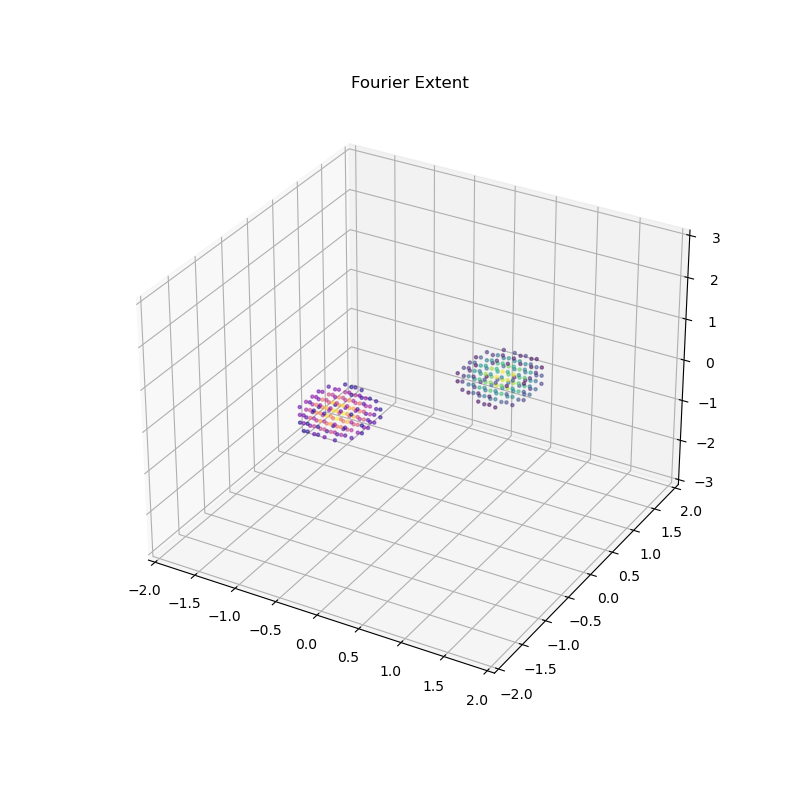

Filter Symmetric : False


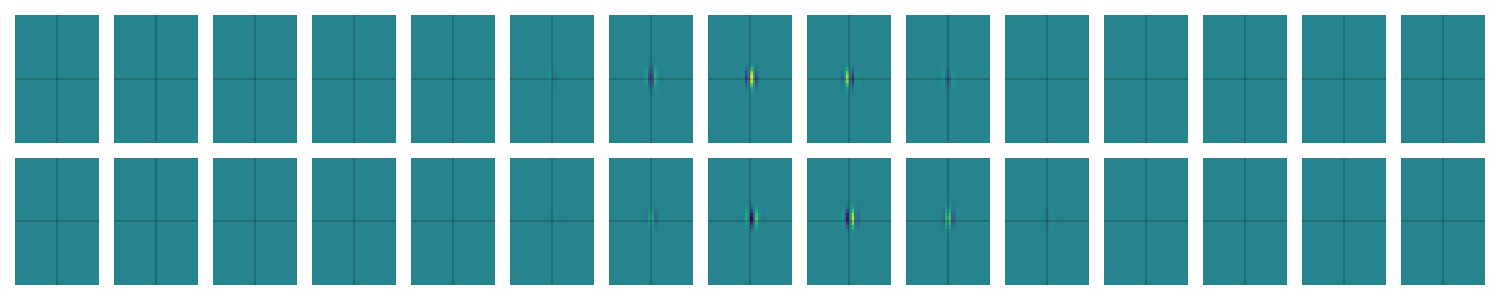

In [7]:
#demo one
def inverse_power_spec(filter):
    #complex_spec = ampspec * np.exp(1j * np.zeros_like(ampspec))
    filter = np.fft.ifftn(np.fft.ifftshift(filter)) #unshift 
    filter = np.fft.fftshift(filter)
    filter_real = np.real(filter) #real pair filter
    filter_imag = np.imag(filter) #imag pair filter
    return(filter_real,filter_imag)

#c/o chatgpt
def check_fourier_symmetry(F):
    # Check if the Fourier transform F has Hermitian symmetry
    # F should be a 2D array
    return np.allclose(F, np.conj(np.flipud(np.fliplr(F))))

def plot_filter_mesh(xs,ys,zs,filt,ax=None,use_keep_mask=True,cmap='viridis'):
    filter_amplitude = np.abs(filt)
    max_amplitude = np.max(filter_amplitude)
    if(use_keep_mask):
        keep_mask = np.where(filter_amplitude > (max_amplitude/2))    
        xs = xs[keep_mask]
        ys = ys[keep_mask]
        zs = zs[keep_mask]
        filter_amplitude = filter_amplitude[keep_mask]
    if(ax==None):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs,ys,zs,c=filter_amplitude,cmap=cmap,marker='.',alpha=0.5)
    # fig.colorbar()
    return(ax)

scales = [1,2]
orientations = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
heights = [1]

scale = scales[0]
orientation = orientations[0]
heights = heights[0]

xyspace=np.linspace(-2,2,num=32)
tspace=np.linspace(-3,3,num=32)
xs, ys, zs = np.meshgrid(xyspace, xyspace, tspace)

fourier_filter = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, height, norm=False, separate_pairs=False)
fourier_filter_real, fourier_filter_imag = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, height, norm=False, separate_pairs=True)


#plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax = plot_filter_mesh(xs,ys,zs,fourier_filter_real,ax,cmap='viridis')
ax = plot_filter_mesh(xs,ys,zs,fourier_filter_imag,ax,cmap='plasma')
ax.set_xlim(np.min(xyspace), np.max(xyspace))
ax.set_ylim(np.min(xyspace), np.max(xyspace))
ax.set_zlim(np.min(tspace), np.max(tspace))
#fig.colorbar()
plt.title('Fourier Extent')
plt.show()

#plot fourier Filters
fig = plt.figure(figsize=(15, 3))
filter_real, filter_imag = inverse_power_spec(fourier_filter)

def check_fourier_symmetry(F):
    # Check if the Fourier transform F has Hermitian symmetry
    # F should be a 2D array
    return np.allclose(F, np.conj(np.flipud(np.fliplr(F))))

fcombined = filter_real + 1*j+filter_imag
print(f'Filter Symmetric : {check_fourier_symmetry(fcombined)}')

#plot spatiotemporal filters
vmin=np.min((filter_real,filter_imag))
vmax=np.max((filter_real,filter_imag))
nslices = 15
slices = np.linspace(0,len(zs)-1,nslices,dtype=int)
f=0
for i in slices:
    f+=1
    plt.subplot(2,nslices,f)
    plt.pcolormesh(xyspace, xyspace, filter_real[:,:,i],vmin=vmin,vmax=vmax)
    #plt.pcolormesh(xyzspace, xyzspace, filter_real[:,:,i],cmap='Greys_r')
    plt.axis('off')
    plt.axhline(0,color='black',linewidth = 0.25) # x = 0
    plt.axvline(0,color='black',linewidth = 0.25) # y = 0
    plt.subplot(2,nslices,f+nslices)
    plt.pcolormesh(xyspace, xyspace, filter_imag[:,:,i],vmin=vmin,vmax=vmax)
    plt.axis('off')
    plt.axhline(0,color='black',linewidth = 0.25) # x = 0
    plt.axvline(0,color='black',linewidth = 0.25) # y = 0
plt.tight_layout()
plt.show()


## Generate Filter Set for Downstream Use

Scale 1
Orientation 0
Height 1


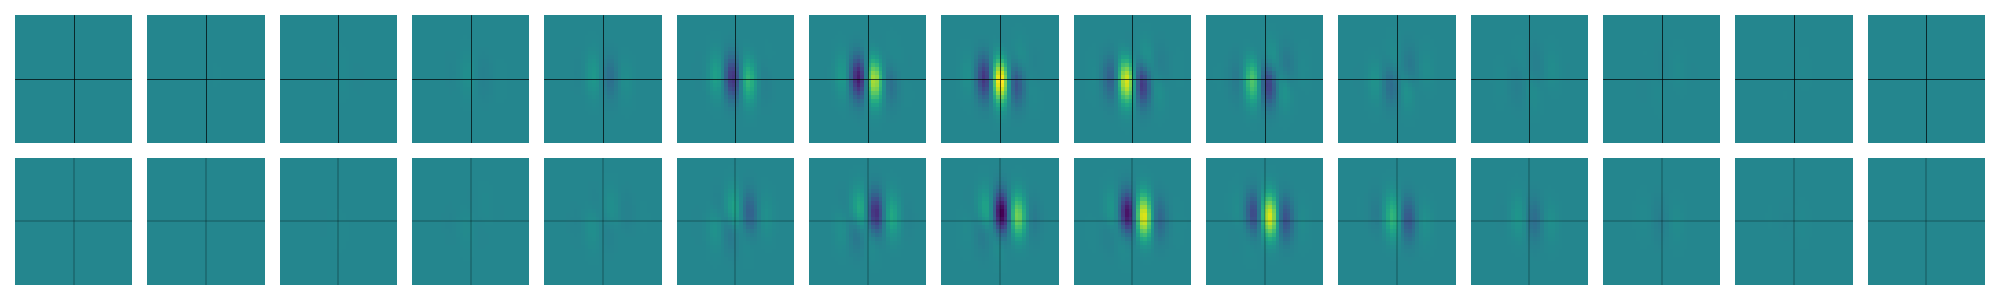

Scale 1
Orientation 0.7853981633974483
Height 1


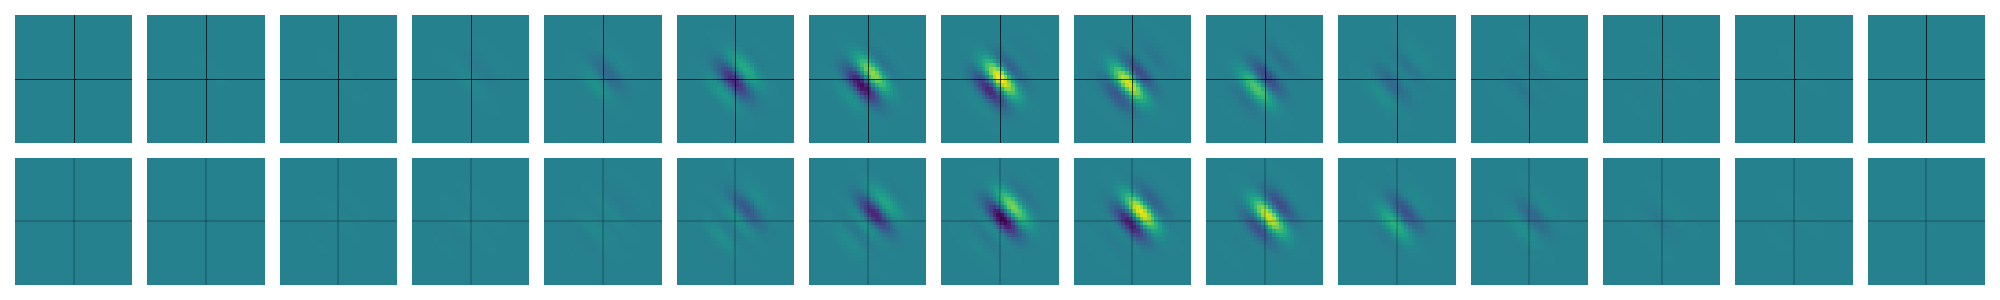

Scale 1
Orientation 1.5707963267948966
Height 1


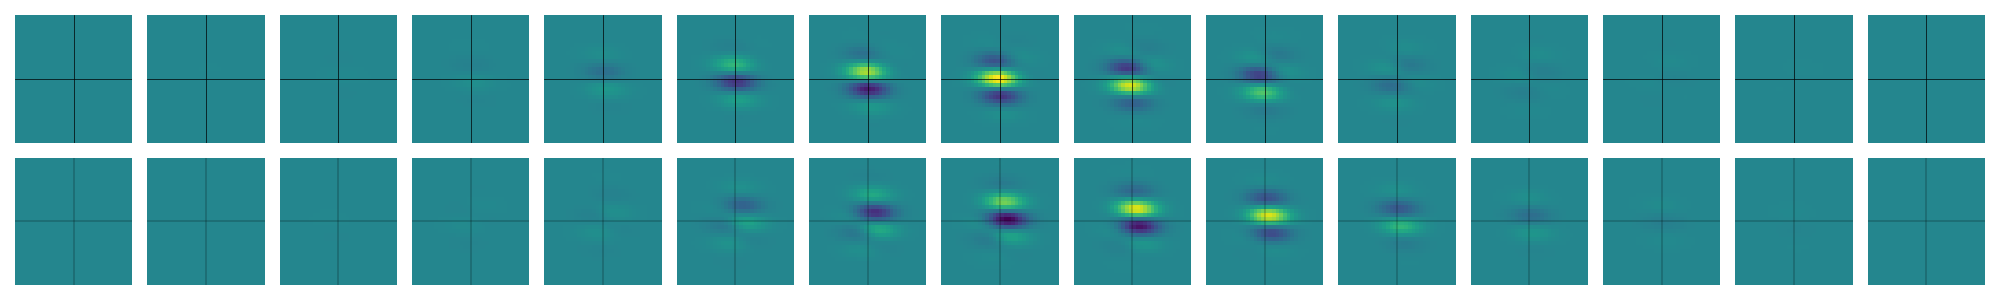

Scale 1
Orientation 2.356194490192345
Height 1


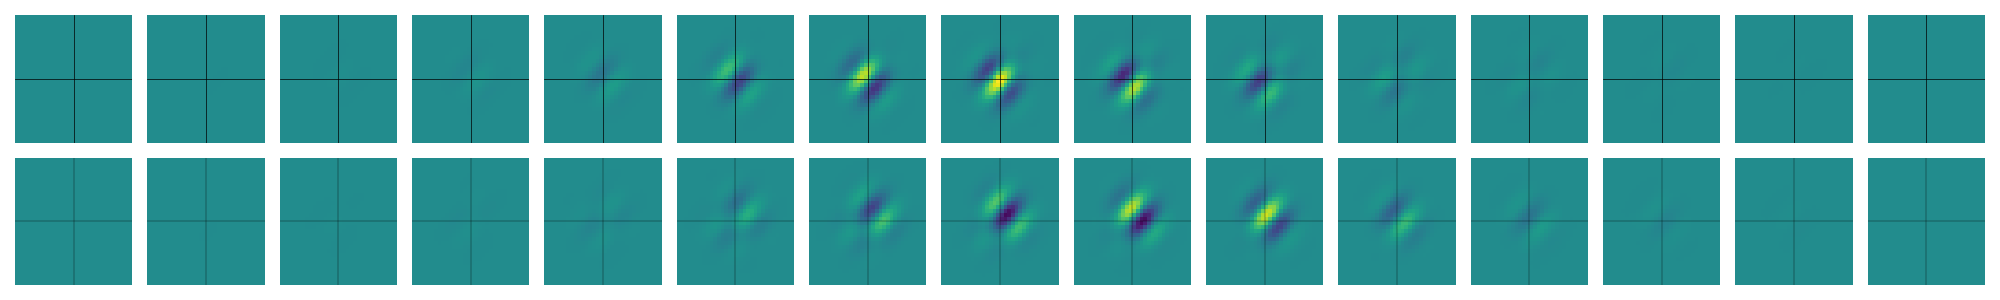

Scale 1
Orientation 3.141592653589793
Height 1


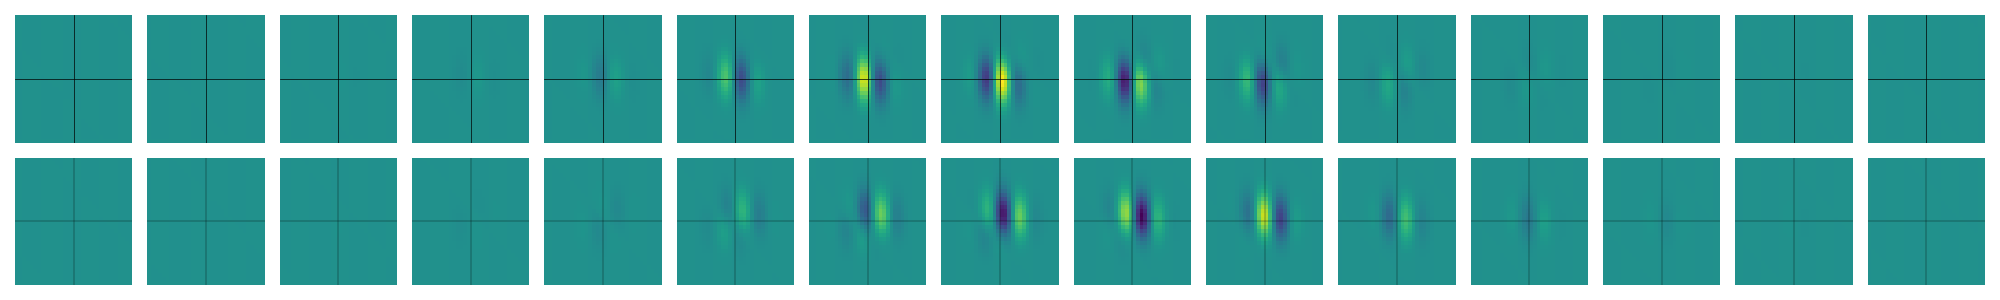

Scale 1
Orientation 3.9269908169872414
Height 1


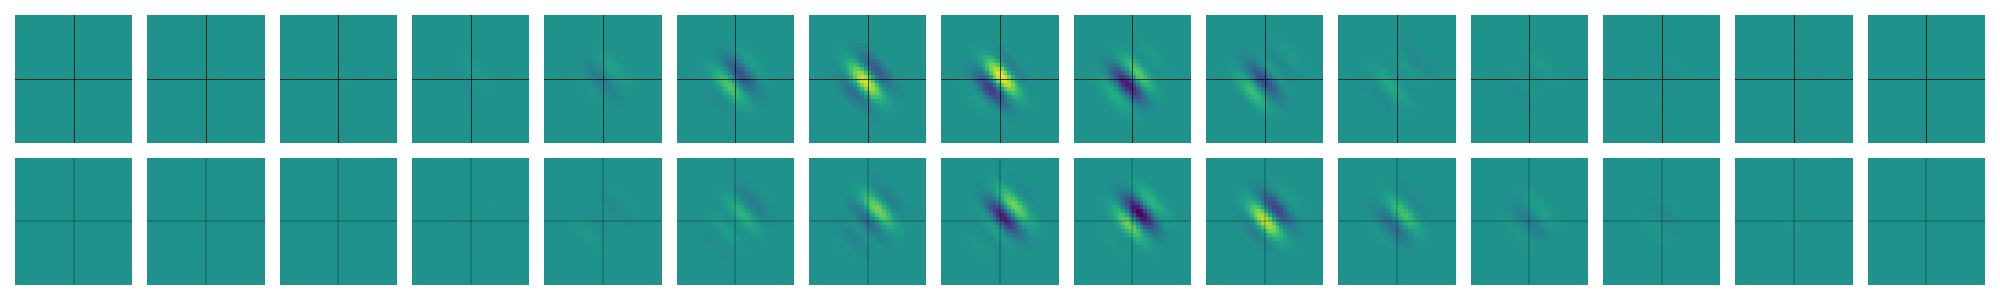

Scale 1
Orientation 4.71238898038469
Height 1


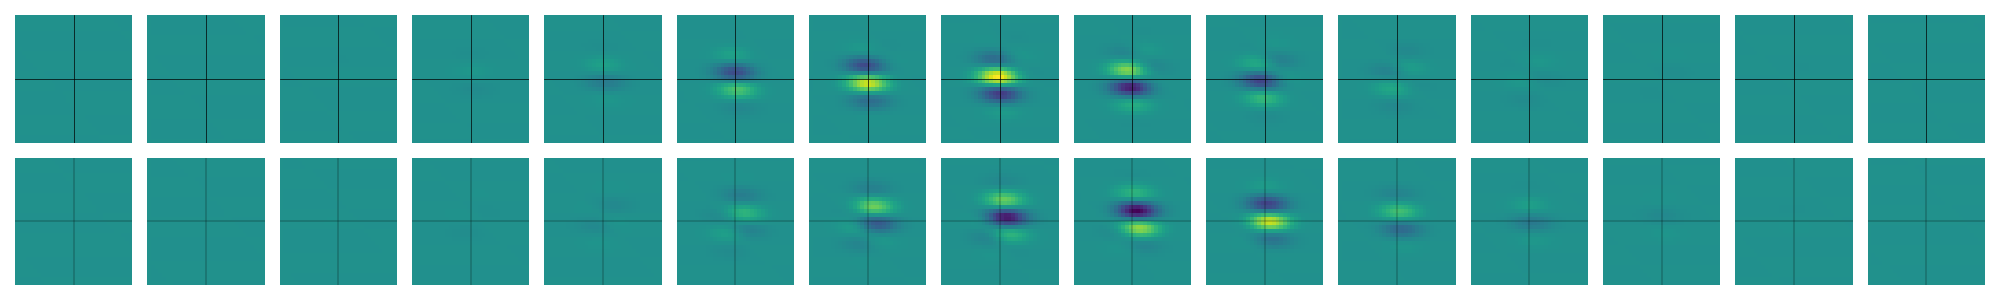

Scale 1
Orientation 5.497787143782138
Height 1


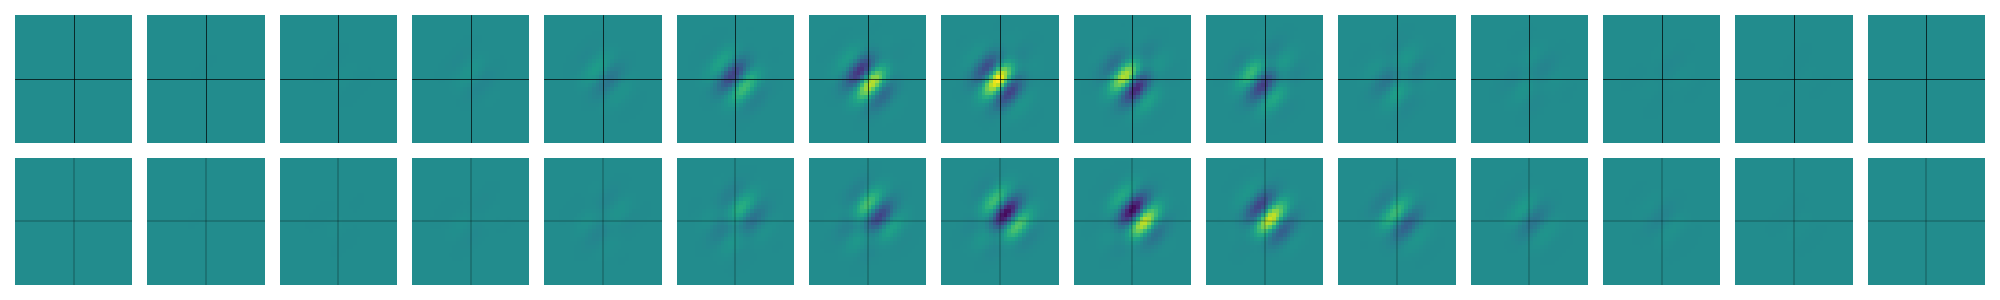

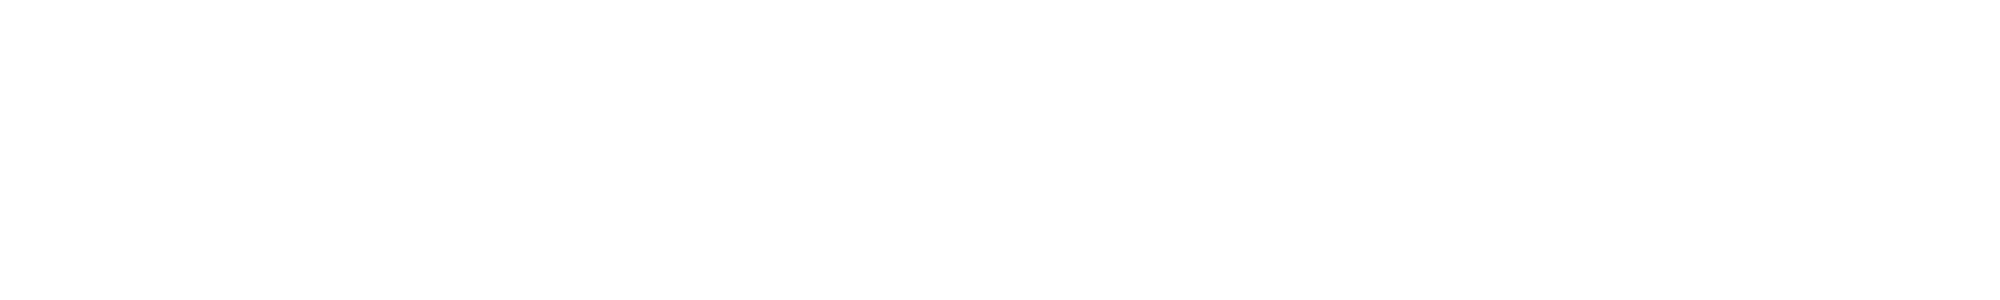

In [8]:
normalize=False

#pick our scales & centers
#scales = [1,2,4]
scales = [1]
orientations = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
#elevations = [0,pi/4,pi/2,3*pi/4]
heights = [1]

filt_size = 32
xyspace = np.linspace(-5,5, num=filt_size)
tspace = np.linspace(-5,5, num=filt_size)
# Setup space progression
xs, ys, zs = np.meshgrid(xyspace, xyspace, tspace)

for k, scale in enumerate(scales):
    
    #plot spatiotemporal filters
    fig = plt.figure(figsize=(20, 3))
    vmin=np.min((filter_real,filter_imag))
    vmax=np.max((filter_real,filter_imag))
    nslices = 15
    slices = np.linspace(0,len(zs)-1,nslices,dtype=int)
    
    for i, orientation in enumerate(orientations):        
        for j, height in enumerate(heights):

            print(f'Scale {scale}')
            print(f'Orientation {orientation}')
            print(f'Height {height}')
            
            fourier_filter = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, height, norm=False, separate_pairs=False)
            filter_real, filter_imag = inverse_power_spec(fourier_filter)
            
            #plot spatiotemporal filters
            fig = plt.figure(figsize=(20, 3))
            vmin=np.min((filter_real,filter_imag))
            vmax=np.max((filter_real,filter_imag))
            nslices = 15
            slices = np.linspace(0,len(zs)-1,nslices,dtype=int)
            f=0
            for i in slices:
                f+=1
                plt.subplot(2,nslices,f)
                # filter_pair = np.concatenate((filter_real, filter_imag), axis=0)
                #print(len(xyspace))
                #print(filter_real.shape)
                plt.pcolormesh(xyspace, xyspace, filter_real[:,:,i],vmin=vmin,vmax=vmax)
                #plt.pcolormesh(xyzspace, xyzspace, filter_real[:,:,i])
                plt.axhline(0,color='black',linewidth = 0.5) # x = 0
                plt.axvline(0,color='black',linewidth = 0.5) # y = 0
                plt.axis('off')
                plt.subplot(2,nslices,f+nslices)
                plt.pcolormesh(xyspace, xyspace, filter_imag[:,:,i],vmin=vmin,vmax=vmax)
                #plt.pcolormesh(xyzspace, xyzspace, filter_imag[:,:,i])
                plt.axhline(0,color='black',linewidth = 0.25) # x = 0
                plt.axvline(0,color='black',linewidth = 0.25) # y = 0
                plt.axis('off')
            plt.tight_layout()
            plt.show()



## Make a movie

In [9]:
import matplotlib.animation as animation
import os
from IPython.display import Video
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

normalize=False
num_pixels = 32
num_frames = 32

#pick our scales & centers
#scales = [1,2,4]
scales = [1,2,4]
orientations = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
heights = [1,2,4]

# Setup space progression
xyspace = np.linspace(-5,5, num=num_pixels)
tspace = np.linspace(-5,5,num=num_frames)
xs, ys, zs = np.meshgrid(xyspace, xyspace, tspace)
#print(len(xs),len(ys),len(zs))

# fig, axes = plt.subplots(2, 15, figsize=(20, 6))

# Create output directory
output_dir = f'filter_movies_norm{normalize}_{num_frames}'
os.makedirs(output_dir, exist_ok=True)

def create_movie(scale, orientation, height, filter_real, filter_imag, filename):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    #get ranges for each filter
    vmin_real = np.min(filter_real)
    vmax_real = np.max(filter_real)
    vmin_imag = np.min(filter_imag)
    vmax_imag = np.max(filter_imag)

    nslices = len(zs)
    slices = np.linspace(0, nslices-1, nslices, dtype=int)

    # Create colorbars
    im_real = axes[0].pcolormesh(xyspace, xyspace, filter_real[:, :, 0], vmin=vmin_real, vmax=vmax_real)
    im_imag = axes[1].pcolormesh(xyspace, xyspace, filter_imag[:, :, 0], vmin=vmin_imag, vmax=vmax_imag)
    
    divider_real = make_axes_locatable(axes[0])
    divider_imag = make_axes_locatable(axes[1])
    cax_real = divider_real.append_axes('right', size='5%', pad=0.05)
    cax_imag = divider_imag.append_axes('right', size='5%', pad=0.05)
    
    fig.colorbar(im_real, cax=cax_real, orientation='vertical')
    fig.colorbar(im_imag, cax=cax_imag, orientation='vertical')

    def update_plot(frame):
#         #print(xyspace.shape, filter_real.shape)
        slice_idx = slices[frame]
        axes[0].clear()
        axes[1].clear()

        im_real = axes[0].pcolormesh(xyspace, xyspace, filter_real[:, :, slice_idx], vmin=vmin_real, vmax=vmax_real)
        axes[0].set_aspect('equal')
        axes[0].set_title(f'Real part, Slice {slice_idx}')
        
        im_imag = axes[1].pcolormesh(xyspace, xyspace, filter_imag[:, :, slice_idx], vmin=vmin_imag, vmax=vmax_imag)
        axes[1].set_aspect('equal')
        axes[1].set_title(f'Imaginary part, Slice {slice_idx}')
           
        for ax in axes:
            ax.axhline(0, color='black', linewidth=0.25)
            ax.axvline(0, color='black', linewidth=0.25)
            ax.axis('off')
        
        # Update colorbars
        fig.colorbar(im_real, cax=cax_real, orientation='vertical')
        fig.colorbar(im_imag, cax=cax_imag, orientation='vertical')
    
#         f1 = axes[0].pcolormesh(xyspace, xyspace, filter_real[:, :, slice_idx], vmin=vmin, vmax=vmax)
#         axes[0].set_aspect('equal')
#         axes[0].set_title(f'Real part, Slice {slice_idx}')
#         divider = make_axes_locatable(axes[0])
#         cax = divider.append_axes('right', size='5%', pad=0.05)
#         fig.colorbar(f1, cax=cax, orientation='vertical');
#         fig.colorbar(f1,cax=axes[0])
#         axes[1].pcolormesh(xyspace, xyspace, filter_imag[:, :, slice_idx], vmin=vmin, vmax=vmax)
#         axes[1].set_aspect('equal')
#         axes[1].set_title(f'Imaginary part, Slice {slice_idx}')
#         for ax in axes:
#             ax.axhline(0, color='black',linewidth = 0.25) # x = 0
#             ax.axvline(0, color='black',linewidth = 0.25) # y = 0
#             ax.axis('off')
# # 
    ani = animation.FuncAnimation(fig, update_plot, frames=nslices, repeat=False)
    ani.save(filename, writer='ffmpeg', fps=16)
    plt.close(fig)

for k, scale in enumerate(scales):
   for i, orientation in enumerate(orientations):
        for j, height in enumerate(heights):
            ordeg = int(math.degrees(orientation))

            print(f'Generating movie for Scale {scale}, Orientation {ordeg}, height {height}')
            
            fourier_filter = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, height, norm=False, separate_pairs=False)
            filter_real, filter_imag = inverse_power_spec(fourier_filter)
            
            filename = os.path.join(output_dir, f'filter_scale{scale}_orientation{ordeg}_height{height}.mp4')
            create_movie(scale, orientation, height, filter_real, filter_imag, filename)

#show the last video
Video(filename)

# import shutil
# shutil.make_archive('filter_movies.zip', 'zip', './filter_movies')

Generating movie for Scale 1, Orientation 0, height 1
Generating movie for Scale 1, Orientation 0, height 2
Generating movie for Scale 1, Orientation 0, height 4
Generating movie for Scale 1, Orientation 45, height 1
Generating movie for Scale 1, Orientation 45, height 2
Generating movie for Scale 1, Orientation 45, height 4
Generating movie for Scale 1, Orientation 90, height 1
Generating movie for Scale 1, Orientation 90, height 2
Generating movie for Scale 1, Orientation 90, height 4
Generating movie for Scale 1, Orientation 135, height 1
Generating movie for Scale 1, Orientation 135, height 2
Generating movie for Scale 1, Orientation 135, height 4
Generating movie for Scale 1, Orientation 180, height 1
Generating movie for Scale 1, Orientation 180, height 2
Generating movie for Scale 1, Orientation 180, height 4
Generating movie for Scale 1, Orientation 225, height 1
Generating movie for Scale 1, Orientation 225, height 2
Generating movie for Scale 1, Orientation 225, height 4
Gene

## Save Filter Banks - Numpy

In [10]:
import torch
#pick our scales & centers
#scales = [1,2,4]
scales = [1,2,4]
orientations = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
heights = [0,1,2,4]

normalize=False
filt_size=32

# Setup space progression
xyzspace = np.linspace(-10,10, num=filt_size)
xs, ys, zs = np.meshgrid(xyzspace, xyzspace, xyzspace)

# Create output directory
output_dir = f'filter_banks_norm{normalize}_{filt_size}'
numpy_fname = 'filters_numpy.pkl'
torch_fname = 'filters_torch.pkl'
os.makedirs(output_dir, exist_ok=True)
print(output_dir)

#create nested dictionary - nuumpy
filter_dict_numpy = {}
filter_dict_torch = {}
for filter_dict in [filter_dict_numpy,filter_dict_torch]:
    filter_dict['fourier'] = {}
    filter_dict['spatiotemporal'] = {}
    filter_dict['fourier']['re'] = {}
    filter_dict['fourier']['im'] = {}
    filter_dict['spatiotemporal']['re'] = {}
    filter_dict['spatiotemporal']['im'] = {}

#loop through and create filters
for k, scale in enumerate(scales):
    for i, orientation in enumerate(orientations):
        for j, elevation in enumerate(heights):
            
            #create filters
            fourier_filter_re, fourier_filter_im = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, elevation, norm=normalize, separate_pairs=True)
            st_filter_re, st_filter_im = inverse_power_spec(fourier_filter_re + 1j*fourier_filter_im)
            #add filter to dictionary - Numpy
            filter_dict_numpy['fourier']['re'][f'{scale}-{orientation}-{elevation}'] = fourier_filter_re
            filter_dict_numpy['fourier']['im'][f'{scale}-{orientation}-{elevation}'] = fourier_filter_im
            filter_dict_numpy['spatiotemporal']['re'][f'{scale}-{orientation}-{elevation}'] = st_filter_re
            filter_dict_numpy['spatiotemporal']['im'][f'{scale}-{orientation}-{elevation}'] = st_filter_im
            #add filter to dictionary - Torch
            filter_dict_torch['fourier']['re'][f'{scale}-{orientation}-{elevation}'] = torch.from_numpy(fourier_filter_re)
            filter_dict_torch['fourier']['im'][f'{scale}-{orientation}-{elevation}'] = torch.from_numpy(fourier_filter_im)
            filter_dict_torch['spatiotemporal']['re'][f'{scale}-{orientation}-{elevation}'] = torch.from_numpy(st_filter_re)
            filter_dict_torch['spatiotemporal']['im'][f'{scale}-{orientation}-{elevation}'] = torch.from_numpy(st_filter_im)

            
import pickle 

with open(os.path.join(output_dir,numpy_fname), 'wb') as f:
    pickle.dump(filter_dict_numpy, f)
with open(os.path.join(output_dir,torch_fname), 'wb') as f:
    pickle.dump(filter_dict_torch, f)
print('done!')

filter_banks_normFalse_32
done!
